# Superhero Name Generator

Importing the data and creating a tokenizer

In [1]:
import tensorflow as tf 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
tf.__version__

'2.9.1'

In [2]:
tf.random.set_seed(0)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , Conv1D , MaxPool1D , LSTM , Dense

In [4]:
with open( 'C:/Users/HP/Downloads/GitHub/Super-Hero-Name-Generator/Names.txt' , 'r') as file :
    data = file.read()

data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [5]:
tokenizer = Tokenizer( filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~' , split='\n' )

In [6]:
tokenizer.fit_on_texts(data)

In [7]:
char_to_index = tokenizer.word_index
index_to_char = dict((value , key) for key , value in char_to_index.items())

index_to_char

{1: '\t',
 2: 'a',
 3: 'e',
 4: 'r',
 5: 'o',
 6: 'n',
 7: 'i',
 8: ' ',
 9: 't',
 10: 's',
 11: 'l',
 12: 'm',
 13: 'h',
 14: 'd',
 15: 'c',
 16: 'u',
 17: 'g',
 18: 'k',
 19: 'b',
 20: 'p',
 21: 'y',
 22: 'w',
 23: 'f',
 24: 'v',
 25: 'j',
 26: 'z',
 27: 'x',
 28: 'q'}

## Converting between names and sequences

In [8]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [9]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [10]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [11]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [12]:
def seq_to_name(seq):
    return ''.join([index_to_char[i] for i in seq if i != 0])

In [13]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Creating sequences and padding all sequences

In [14]:
sequences = []

for name in names :
    seq = name_to_seq(name)
    if len(seq) >= 2 :
        sequences += [seq[:i] for i in range(2 , len(seq) + 1)]

In [15]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [16]:
max_len = max([len(x) for x in sequences])
max_len

33

In [17]:
padded_sequences = pad_sequences( sequences , padding = 'pre' , maxlen = max_len )

padded_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16])

In [18]:
padded_sequences.shape

(88278, 33)

## Creating Training and Test Sets

In [19]:
x , y = padded_sequences[:,:-1] , padded_sequences[:,-1]
[x.shape , y.shape]

[(88278, 32), (88278,)]

In [20]:
X_train , X_test , Y_train , Y_test = train_test_split(x , y , train_size= 0.8 , random_state= 4)

[X_train.shape,Y_train.shape,X_test.shape,Y_test.shape]

[(70622, 32), (70622,), (17656, 32), (17656,)]

In [21]:
num_chars = len(char_to_index.keys()) + 1
num_chars

29

## Model Creating

In [22]:
model = Sequential([
                    Embedding(num_chars , 8 , input_length= max_len - 1 ) ,    
                    Conv1D(64 , 5 , strides= 1 , activation= 'tanh' , padding= 'causal') ,
                    MaxPool1D(2) ,
                    LSTM(32) ,
                    Dense(num_chars , activation='softmax')
])

model.compile(
                loss = 'sparse_categorical_crossentropy' ,
                optimizer = 'adam' ,
                metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

## Model training

In [23]:
a = model.fit ( X_train , Y_train , validation_data = (X_test,Y_test) , epochs = 50 , verbose = 2 , 
                callbacks= [EarlyStopping(monitor='val_accuracy' , patience = 3)])

Epoch 1/50
2207/2207 - 46s - loss: 2.7400 - accuracy: 0.1901 - val_loss: 2.5883 - val_accuracy: 0.2216 - 46s/epoch - 21ms/step
Epoch 2/50
2207/2207 - 33s - loss: 2.5498 - accuracy: 0.2339 - val_loss: 2.4988 - val_accuracy: 0.2554 - 33s/epoch - 15ms/step
Epoch 3/50
2207/2207 - 18s - loss: 2.4783 - accuracy: 0.2533 - val_loss: 2.4440 - val_accuracy: 0.2673 - 18s/epoch - 8ms/step
Epoch 4/50
2207/2207 - 19s - loss: 2.4249 - accuracy: 0.2679 - val_loss: 2.3972 - val_accuracy: 0.2808 - 19s/epoch - 9ms/step
Epoch 5/50
2207/2207 - 19s - loss: 2.3840 - accuracy: 0.2782 - val_loss: 2.3660 - val_accuracy: 0.2877 - 19s/epoch - 9ms/step
Epoch 6/50
2207/2207 - 20s - loss: 2.3511 - accuracy: 0.2871 - val_loss: 2.3409 - val_accuracy: 0.2939 - 20s/epoch - 9ms/step
Epoch 7/50
2207/2207 - 24s - loss: 2.3216 - accuracy: 0.2961 - val_loss: 2.3132 - val_accuracy: 0.3032 - 24s/epoch - 11ms/step
Epoch 8/50
2207/2207 - 19s - loss: 2.2963 - accuracy: 0.3058 - val_loss: 2.2915 - val_accuracy: 0.3099 - 19s/epoch 

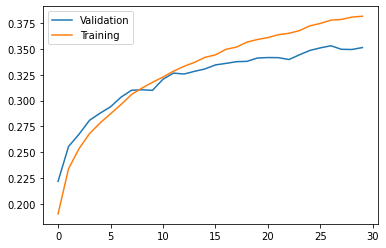

In [24]:
epochs_ran = len(a.history['loss'])

plt.plot(range(0, epochs_ran) , a.history['val_accuracy'] , label = 'Validation')
plt.plot(range(0, epochs_ran) , a.history['accuracy'] , label = 'Training')
plt.legend()
plt.show()

# Generating Names

In [25]:
def generate_name(seed):
    for i in range(40):
        seq = name_to_seq(seed)
        padded = pad_sequences( [seq] , padding = 'pre' , maxlen = max_len - 1 , truncating = 'pre')
        pred = model.predict(padded)[0]
        pred_char = index_to_char[tf.argmax(pred).numpy()]
        seed += pred_char

        if pred_char == '\t' :
            break

    print(seed)

In [26]:
generate_name('desai')

1/1 [==============================] - 0s 19ms/step
desain strange	
